# Capítulo 3: Clasificación

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

X, y = mnist['data'], mnist['target']

(-0.5, 27.5, 27.5, -0.5)

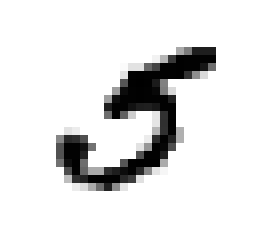

In [2]:
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = 'nearest')

plt.axis('off')

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000]

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y[shuffle_index]

## Entrenando un Clasificador Binario

El clasificador binario implementado solo reconocerá si el número es o no es un 5

In [4]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Crear un clasificador tipo Stochastic Gradient Descent. Este tipo de clasificador puede manejar grandes sets de datos de forma eficiente 

In [5]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

## Medidas de Desempeño

### Medir Precisión Usando Cross-Validation

In [6]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([ 0.96695,  0.95525,  0.94125])

Para tener una medida real del desempeño del clasificador, es importante compararlo con el de un dummy classifier.

In [7]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    
    def predict(self, X):
        
        return np.zeros((len(X), 1), dtype = bool)

In [8]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([ 0.9086 ,  0.91135,  0.909  ])

Para sets de datos que tienen clases mucho más frecuentes que otras, la exactitud (accuracy) no es una medida adecuada de desempeño como se puede observar comparando el desempeño del dummy classifier y el clasificador binario. 

### Matriz de Confusión

In [9]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

La función `cross_val_predict()` hace una cross_validation, pero retorna la predicción hecha en cada grupo en vez de de los puntajes. De esta forma se garantiza que la predicción hecha es hecha por un modelo que nunca vio los datos que está prediciendo durante el entrenamiento.

In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52841,  1738],
       [  993,  4428]])

Cada fila en la matriz representa una clase, mientras que cada columna representa la clase que se predijo. 

La primera fila es la clase negativa (imágenes que nos son 5). La esquina superior izquierda muestra las imágenes que fueron clasificadas correctamente como *no 5* (*verdaderos negativos (TN)*)mientras que ls superior derecha muestra las que fueron clasificadas *5* sin serlo (*falsos positivos (FP)*). 

La segunda fila considera la clase positiva (imágenes que son 5). La esquina inferior izquierda muestra el número de imágenes que fue incorrectamente clasificado como *no 5* (*falsos negativos (FN)*), mientras que la esquina inferior derecha muestra las imágenes que fueron clasificadas correctamente como *5* (*verdaderos positivos (TP)*).

**Un clasificador perfecto tendría solo elementos en la diagonal de la matriz.**

Para tener la información dada en la matriz de confusión, se definen métricas a partir de esta matriz.

En primer lugar, se define la eficacia del modelo prediciendo las clases positivas. Esta métrica se denomina precisión (**precision**):

$precision = \frac{TP}{TP+FP}$


Se podría obtener un puntaje perfecto asegurándose que el clasificador hiciera solamente una predicción correcta de todo el set de datos. Como en este caso se estaría ignorando casi todo el set de datos, y aún así se tiene un puntaje perfecto, la precisión se usa en conjunto con el *recall*. Recall es fracción de muestras positivas que son detectadas por el clasificador.

$recall = \frac{TP}{TP+FN}$



### Precision y Recall

In [11]:
from sklearn.metrics import precision_score, recall_score

print('Puntaje precision: {}'.format(precision_score(y_train_5, y_train_pred)))
print('Puntaje recall: {}'.format(recall_score(y_train_5, y_train_pred)))

Puntaje precision: 0.7181316899124229
Puntaje recall: 0.8168234643054787


De acuerdo al puntaje de precisión, el clasificador está en lo correcto el 88% de la veces cuando clasifica una instancia como *5*. Adicionalmente, de acuerdo al puntaje de recall, el clasificador solo detecta el 70% de los *5s* en las imágenes.

Para unir los puntajes de recall y precisión en una sola métrica, se usa frecuentemente el $F_{1}$ score. El $F_{1}$ score es la media harmónica entre los puntajes de recall y precisión. Esto garantiza que el clasificador solo tendrá un $F_{1}$ score alto si el recall y la precisión también son altos.

$F_{1} = 2\times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$

In [12]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7643048243721412

Como se mencionó anteriormente, el $F_{1}$ score favorece a los clasificadores que tienen puntajes altos de recall y precisión. Se debe tener en cuenta que no siempre es deseable tener ambos puntajes altos. Por ejemplo, si se quiere entrenar un clasificador que detecte videos seguros para niños, es mejor que el clasificador rechace muchos videos seguros (bajo recall) pero deje solamente los seguros (alta precisión). Un ejemplo en el caso contrario es un clasificador que detecte un potencial ladrón en imágenes de vigilancia. En este caso se tendrían algunos casos de personas que no son ladrones pero que son identificados como tal (baja precisión), pero la gran mayoría de ladrones serán capturados (alto recall).

### Precision/Recall Tradeoff

Como los clasificadores dependen de un valor umbral para clasificar una instancia, siempre va a haber un intercambio entre el valor de recall y precisión. 

Scikit-Learn no provee una forma de manipular el umbral de decisión de un classificador. Sin embargo, se puede usar la función `decision_function()` que retorna el puntaje de cada instancia. Se puede establecer un umbral manualmente usando los puntajes calculados por esa función de decisión.

Example for only one image

In [13]:
threshold = 2000
y_scores = sgd_clf.decision_function([some_digit])
y_some_digit_pred = (y_scores > threshold)

Example using `cross_val_predict()`

In [14]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

Una vez se tienen los puntajes para cada una de las instancias, es posible calcular la precisión y el recall para cualquier umbral posible. De esta manera se puede ajustar el umbral para valores de recall y precisión deseados para el clasificador

In [15]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

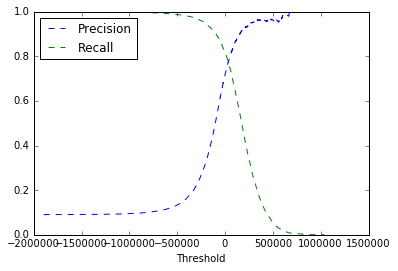

In [16]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc = 'best')
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

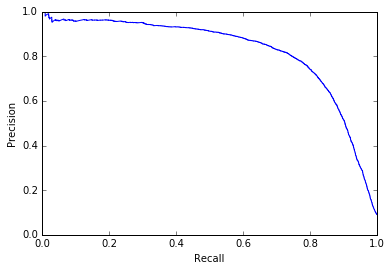

In [17]:
def plot_recall_precision(recalls, precisions):
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
plot_recall_precision(recalls, precisions)

### La Curva ROC

La curva ROC (*receiving operaring characteristic*) gráfica el recall (o *true positive rate*) contra el *false positive rate* (FPR). El FPR  es la razón de las instancias negativas que son clasificadas incorrectamente como positivas. 

$FPR = 1 - TNR$ donde TNR es el *true negative rate* o *specificity*. Esto es, la razón de instancias negativas clasificadas correctamente como negativas.

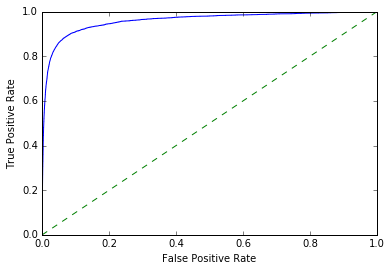

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, label = label)
    plt.plot([0,1], [0,1], 'g--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)

La línea punteada de la gráfica representa un clasificador aleatorio. Un buen clasificador logra la mayor separación posible de la línea punteada. Una forma de usar la curva ROC para medir el desempeño de un clasificador es usar el área bajo la curva (AUC). Un clasificador perfecto tendrá un área bajo la curva de uno, mientras que uno aleatorio tendrá un área bajo la curva de 0.5.

Como las curvas ROC y Precisión-Recall son similares, se debe tener en cuenta en qué casos es apropiado usar cada una de éstas. Se debe escoger la curva PR **cuando la clase positiva es poco frecuente o cuando importan más los falsos positivos que los falsos negativos. ** Por ejemplo, cuando se observa la curva ROC anterior, uno piensa que el clasificador es bastante bueno. Sin embargo, esto pasa porque hay pocas instancias positivas comparadas con las negativas. Por el contrario, la curva PR muestra que el clasificador puede mejorar.

In [19]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.95971164753291782

#### Comparación con un RandomForestClassifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = 'predict_proba')

Algunos clasificadores no tienen una método de `decision_function()`. Sin embargo, estos clasificadores tienen el método `predict_proba()`, el cual contiene una fila por cada instancia y una columna por cada clase. Cada elemento de esta tabla contiene la probabilidad de que dicha instancia sea la clase de la columna. 

Para el caso del RandomForestClassifier, se usará como puntaje la probabilidad de que la instancia sea positiva.

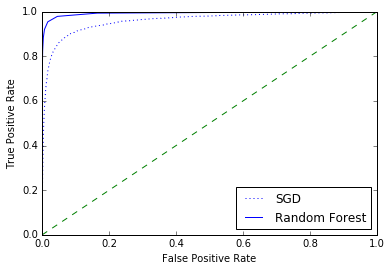

In [21]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='best')


En la gráfica se puede ver que el desempeño del clasificador tipo RandomForest es mejor que el SGD, ya que la curva está más cerca de la esquina superior izquierda. Esto también se puede evidenciar en el puntaje ROC AUC.

In [22]:
roc_auc_score(y_train_5, y_scores_forest)

0.99286574064089494

## Clasificación con Varias Clases

Algunos clasificadores soportan clasificar más de dos clases. Para los que soportan unicamente clasificación binaria, existe la posibilidad de entrenar varios clasificadores para diferenciar entre varias clases.

El primer método consiste en entrenar un clasificador por cada clase. Una vez entrenados, se toma una instancia y se define su clase de acuerdo al clasificador que arroje el mejor puntaje. Este método se denomina uno contra todos (*one-versus-all* (OvA)).

También existe la posibilidad de entrenar un clasificador binario por cada par de clases posible. Este método se denomina uno-contra-uno (*one-versus-one* (OvO)). La ventaja de este método es que los clasificadores sólo tienen que ser entrenados en la parte del dataset que contiene las clases que debe distinguir. Esto supone una ventaja de este método para clasificadores como Support Vector Machine que no escalan muy bien con el tamaño de los datos.

Scikit-Learn detecta automáticamente cuando se está intentando usar un clasificador binario para clasificar varias clases. En esos casos, se aplica el método OvA (excepto para el caso de Support Vector Machine en el que se usa OvO).

In [23]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

Para el caso anterior, Scikit-Learn entrenó 10 clasificadores distintos y a partir de sus puntajes concluyó que el dígito era un cinco.

In [24]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -14940.76744538, -433330.88016455, -353124.83284309,
        -108976.73207652, -413876.68836562,   -6694.29456654,
        -631513.06640524, -373184.27331413, -795195.82791036,
        -724819.55131402]])

**Nota:** Cuando se entrena un clasificador, la lista de clases se almacena en el atributo `classes_`.

En caso de que se quiera forzar el uso de OvA o OvO para algún algoritmo, se puede usar las clases `OneVsOneClassifier` o `OnevsRestClassifier`.

In [25]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

Para los casos en el que el clasificador soporta clasificación de varias clases, basta con entrenar el modelo directamente.

In [26]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [27]:
forest_clf.predict_proba([some_digit])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

Para obtener mejores resultados en la clasificación, se pueden hacer un scaling de los datos

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([ 0.91286743,  0.91019551,  0.90703606])

## Error Analysis

Analizar errores usando matriz de confusión

In [29]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5724,    3,   23,   11,   11,   52,   49,    9,   38,    3],
       [   2, 6496,   43,   23,    5,   37,    9,   11,  107,    9],
       [  57,   41, 5333,  112,   73,   24,   90,   51,  163,   14],
       [  47,   39,  138, 5371,    3,  222,   31,   53,  130,   97],
       [  27,   27,   38,    9, 5359,    7,   62,   32,   81,  200],
       [  68,   43,   37,  197,   79, 4623,  111,   25,  153,   85],
       [  30,   25,   48,    2,   41,   96, 5630,    5,   41,    0],
       [  26,   19,   72,   30,   50,   12,    6, 5823,   14,  213],
       [  49,  169,   69,  166,   17,  168,   55,   25, 4997,  136],
       [  42,   36,   27,   90,  159,   32,    2,  240,   75, 5246]])

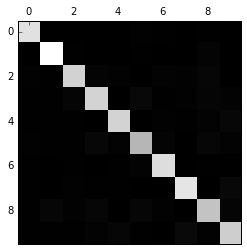

In [30]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

Para obtener más información sobre la clasificación de cada número, es conveniente dividir cada valor en la matriz sobre el número de imágenes en la clase correspondiente. De esta manera es posible comparar tasas de error en lugar de número de errores absoluto, lo que haría que clases que tienen muchas instancias parezcan que tienen un error mayor.

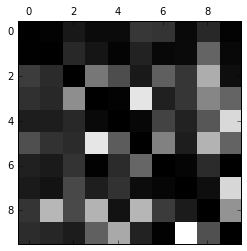

In [31]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

### Clasificación de Multilabel

En ocasiones se le deben asignar varias etiquetas a una sola instancia.

In [32]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [33]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

El clasificador muestra dos clases de la instancia: la imagen analizada no tiene un número mayor o igual a 7 y es un número impar.

### Clasificación Multioutput

La clasificación multioutput es una clasificación en la que cada label puede tener más de una clase, es decir, no es binario.

Un ejemplo de esto es un clasificador que remueva ruido de una imagen. Como para cada pixel el resultado es un valor entre 0 y 255 (intensidad), hay múltiples labels para cada instancia.

In [34]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [37]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

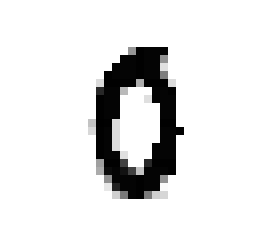

In [38]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[45]])
plot_digit(clean_digit)